## Ívelt, kanyarokkal ellátott sávok észlelése képekhez

Az algoritmus főbb lépései:

* Kamera kalibrációs mátrix és a torzítási együtthatók számítása sakktábla-mintát tartalmazó képek alapján.
* Torzításkorrekció a nyers képen.
* Színtranszformációk, színátmenetek alkalmazáda küszöbértékes bináris kép létrehozásához.
* Perspektív transzformáció végrehajtása a bináris kép javításához. 
* Hisztogram létrehozása a sáv képpontok észlelésére.
* Sáv görbületének és a jármű középpontól való eltérésének számítása.
* Észlelt sávhatárokat visszatranszformálása az eredeti képre (inverz perspektív-tr.).
* Felismert sáv kiszínezése, valamint a sáv görbületi sugarának és a jármű helyzetének numerikus megjelenítése.

### Szükséges kiegészítő függvénykönyvtárak importálása

In [49]:
import numpy as np #matematikai háttér
import pandas as pd #adatelemzési és gépi tanulási feladatokhoz (többdimeiós tömbök támogatása)
import cv2 #gépi látás funkciók
import os #parancsokat futtatása a Python szkriptben
import glob #mappa elérési útvonal (adott mintának megfelelés esetén)
import matplotlib.pyplot as plt #képre történő rajzoláshoz
import pickle #Python-objektum bájtfolyammá alakításának folyamata
import time #idővel kapcsolatos funkciók
#a sorok eredménye legyen látható futtatás során ezen a felületen
%matplotlib inline

### Kamera kalibráció végrehajtása

In [50]:
def calibrate():
    """
    A kamera sakktábla képei alapján történő kalibrálás.
    A kameramátrix és a torzítási együtthatók számításához.
    """
    # 3D tárgypontok eltárolása tömbben
    objp = np.zeros((9*6, 3), np.float32) 
    
    # x és y értékekhez rácspontokat kell rendelni, melyek nem rendelkeznek z-koordinátával
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # T.reshape - új alakzatot ad egy tömbnek az adatai megváltoztatása nélkül

    # Tárgy és képpontok tárolása a kalibrációs képekről
    objpoints = []
    imgpoints = []

    # Kalibrációs képek könyvtárának elérése
    images = glob.glob(r'C:\Users\Eszti\Desktop\Python projects\camera_cal*.jpg')

    for indx, fname in enumerate(images):
        
        img = cv2.imread(fname)
        
        # kalibrációs képek szürkeárnyalatossá alakítása
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # sakktábla belső sarokpontjainak megkeresése 
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        # Amennyiben a feltétel teljesül, a pontok hozzáadásra kerülnek a definiált üres tömbökhöz.
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
        img_size = (img.shape[1], img.shape[0])

    # Kalibráció elvégzése
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Eredmények:
        calibration_param = {} #forgatás és eltolás vektorai
        calibration_param['mtx'] = mtx #kamera mátrix
        calibration_param['dist'] = dist #torzulási együtthatók
        # dump függvény - objektumadatok fájlban tárolása
        pickle.dump( calibration_param, open(r'C:\Users\Eszti\Desktop\Python projects\camera_cal/calibration_pickle.pickle', 'wb') )


In [51]:
calibrate()

### Torzulás mentes kép előállításához a korrekciós adatok behívása

In [52]:
def undistort_img(img, cal_dir = r'C:\Users\Eszti\Desktop\Python projects\camera_cal/calibration_pickle.pickle'):
    """
    'img' a bementi kép, mely torzulással ellátott
    'cal_dir' = mentett kamera mátrix és torzulási együtthatók elérési útja
    """
    
    # Mentett fájl olvasása (bináris módban történő megnyitás)
    with open(cal_dir, mode = 'rb') as f:
        file = pickle.load(f)
        
    mtx = file['mtx'] #kamera mátrix
    dist = file['dist']  #torzulási együtthatók
    
    #objektív torzításának korrigálása az adott kameramátrixhoz és a torzítási együtthatókhoz
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted_img

### Korrekciók alkalmazása sakktábla képre

Text(0.5, 1.0, 'Undistorted image')

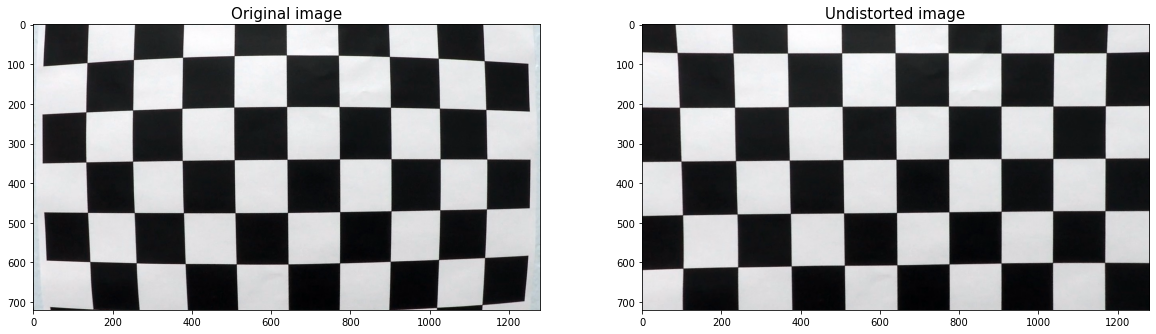

In [53]:
img = cv2.imread(r'C:\Users\Eszti\Desktop\Python projects\/calibration1.jpg')
undistorted_img = undistort_img(img)

#eredmények megjelenítése egymás mellett (1 sor, 2 oszlop)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10)) #téglalap alakú területek méretekkel ellátva a képek számára

ax1.imshow(img) # kép megjelenítése a téglalap alakú területen
ax1.set_title('Original image', fontsize = 15)

ax2.imshow(undistorted_img)
ax2.set_title('Undistorted image', fontsize = 15)

### Korrekciók alkalmazása az úttesre

Text(0.5, 1.0, 'Undistorted image')

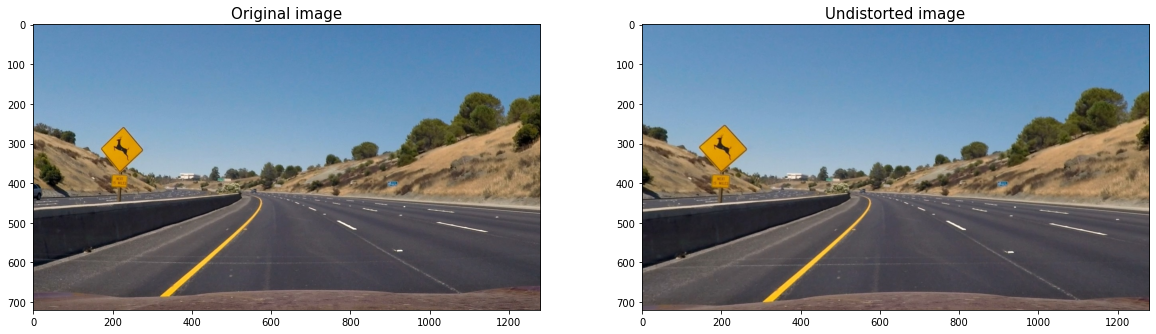

In [54]:
img = cv2.imread(r'C:\Users\Eszti\Desktop\Python projects\curved_lane_test/curve-lane.jpg')

#a cv2 a színcsatornákat BGR formátumban értelmezi 
#a matplotlib számára RGB sorrendbe kell transzformálni
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(img)
ax1.set_title('Original image', fontsize = 15)

ax2.imshow(undistorted_img)
ax2.set_title('Undistorted image', fontsize = 15)

### Színküszöb alkalmazása az élek kiemeléséhez

In [55]:
def img_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 255)): 
    """
    Az'img' bemeneti képnél először a torzulás szűnik meg.
    HLS-ábrázolással az útra vonatkozóan jobb színkontraszt kapható
    Az erős fények és árnyékok zavaró hatása csökken (L- és S- csatorna).
    """
    # bemeneti kép torzulásmentessé tétele
    undistorted_img = undistort_img(img)
    
    # HLS színtérre való áttérés
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h_channel = hls[:, :, 0] # Hue = színárnyalat
    l_channel = hls[:, :, 1] # Lightness = világosság
    s_channel = hls[:, :, 2] # Satuaration = telítettség
    
    # Sobel-operátor használata x-irányban
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    
    # Sobel deriváltak származtatása: világos és sötét részek érintkezésnél
    # abszolút érték vétele, mely az él erősségét jelzi
    abs_sobelx = np.absolute(sobelx)
    
    # Fehér képpontértékek megtalálása (255-ös pixelérték)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))  #numpy tömbben található maximális érték számítása
    
    # Sobel-x gradiens küszöbérték megadása
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Küszöbértékek meghatározása, annak eldöntésére található-e él a képen
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Küszöbértékes képek egymásra illesztve
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    
    # azon pixelek, amelyek valamely küszöbértékes képen szerepelnek "1" értéket kapnak
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Küszöbértékes képek eredményei
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    ax1.imshow(sxbinary, cmap = 'gray')
    ax1.set_title('Sobel x gradiens küszöbérték', fontsize = 15)
    #
    ax2.imshow(s_binary, cmap = 'gray')
    ax2.set_title('Telítettségi csatorna küszöbértéke', fontsize = 15)
    #
    ax3.imshow(color_binary)
    ax3.set_title('Halmozott zöld - x színátmenet, kék - színküszöb', fontsize = 15)
    #
    ax4.imshow(combined_binary, cmap = 'gray')
    ax4.set_title('Halmozott küszöb', fontsize = 15)
    
    return combined_binary, undistorted_img

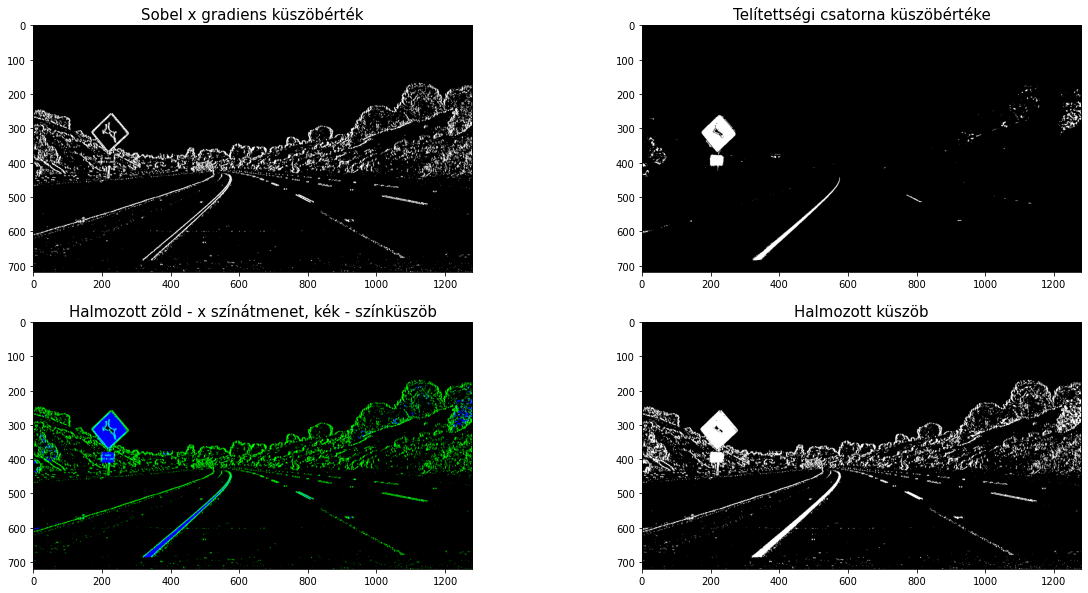

In [56]:
_, _ = img_threshold(cv2.imread(r'C:\Users\Eszti\Desktop\Python projects\curved_lane_test/curve-lane.jpg'))

### Perspektív transzformáció lépései (úttest felülnézeti képének előállításához)
### Inverz Perspektív transzformáció a kásőbbi visszatranszformáláshoz

Text(0.5, 1.0, 'Warped thresholded image')

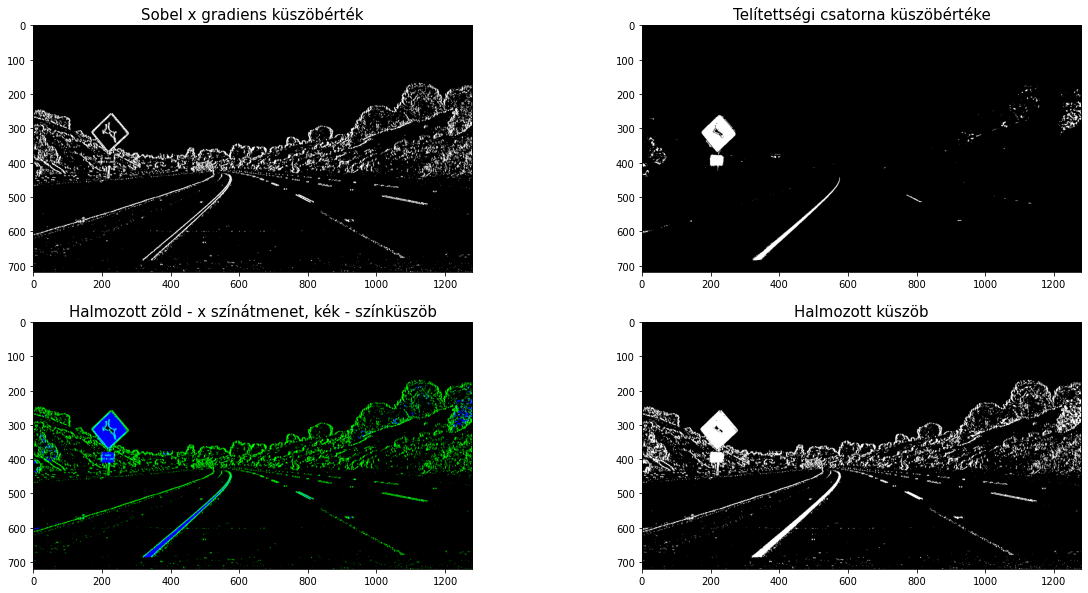

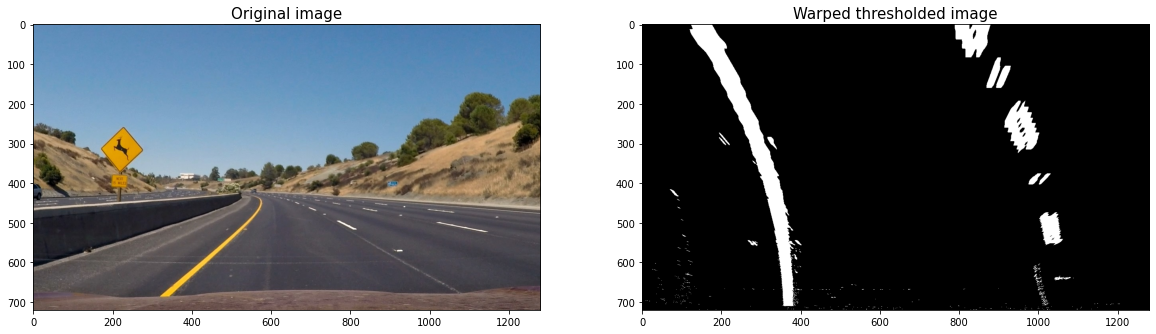

In [57]:
img = cv2.imread(r'C:\Users\Eszti\Desktop\Python projects\curved_lane_test/curve-lane.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
threshold_img, undistorted_img = img_threshold(img)
warped_img = perspective_transform(threshold_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(img)
ax1.set_title('Original image', fontsize = 15)

ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped thresholded image', fontsize = 15)

In [58]:
def perspective_transform(img):
    
    # kétszer 4 db egymásnak megfeleltethető pontpár megadása, a transzformációs mátrix meghatározásához
    #bal alsó, jobb alsó, bal felső, jobb felső koordináták szerinti sorrendben
    src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
    
    img_size = (img.shape[1],img.shape[0])

    #Perspektív transzformáció mátrixának számítása
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Transzformáció végrehajtása
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

# Inverz Perspektív transzformáció (tulajdonképp az előző fordítottja src és dst felcserélésével)
def inv_perspective_transform(img):
    
    dst = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    src = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
    
    img_size = (img.shape[1],img.shape[0])

    # Inverz Perspektív transzformáció mátrixának számítása
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Transzformáció végrehajtása
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

### Hisztogram készítése

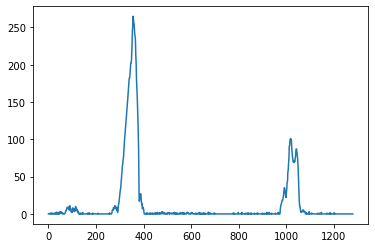

In [59]:
#hisztogram készítése a sávvonalak intenzitás érték alapján történő meghatározásához
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0) #kép alsó tartományába eső x-értékekhez rendelt pixelekről információ 
    return hist
plt.plot(get_hist(warped_img))

### Bal és jobb oldali sávvonlak besorolása

In [60]:
def find_lane_pixels(binary_warped):
    """
    ez videó esetén a videó első képkockáján fut le
    
    bemenet - 'binary_warped' perspektív transzformációval ellátott küszöbértékes kép
    kimenet - a sáv pixelek x and y koordinátái
    
    step 1: bemeneti kép hisztogramjának előállítása
    step 2: hisztogram csúcsainak keresése
    step 3: ablak számára hiperparaméter választása
    step 4: képen levő összes nem 0 pixelértékű pont koodinátáinak összegyűjtése
    step 5: adott ablakba eső összes nem nulla pixel megkapása
    step 6: indexek alapján x,y koordináták
    """
    # Kép alsó feléről hisztogram készítése
    histogram = get_hist(binary_warped)
    
    # csúcsok keresése a hisztogram bal és jobb felén
    # ezek lesznek a bal és jobb vonalak kiindulópontjai
    midpoint = np.int(histogram.shape[0]//2) #hisztogram felező pontjának kijelölés (kép szélességének a fele)
    leftx_base = np.argmax(histogram[:midpoint]) # np.argmax - kiugró értékek megtalálására
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Hiperparaméterek
    # Csúszó-ablakok számának megadása
    nwindows = 9
    
    # Csúszó-ablakok szélessége +/- margó
    margin = 100
    
     # talált pixelek minimális száma, mely után az ablak tovább csúszik
    minpix = 200

    # Ablakok magasságának beállítása a kép magasságának megfelelően
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
   # Összes nem nulla értékékű pixel x és y pozíciójának meghatározása
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
   # Az aktuális pozíciók később frissülnek az egyes ablakokhoz
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Bal- és jobboldali pixelértékek számára üres listák létrehozása
    left_lane_inds = []
    right_lane_inds = []

    # Iteráció indul, mely végig lépked az ablakokon
    for window in range(nwindows):
        
         # bal-és jobboldali ablakok határainak megadása
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ###ablakkeret négy sarokpontjának x és y koordináta értékei az aktuális pozícióka függvényében frissülnek
        win_xleft_low   = leftx_current - margin
        win_xleft_high  = leftx_current + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
         # kereten belüli nem nulla intenzitású pixelek azonosítása###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # 0-tól eltérő pixelek hozzáadásra kerülnek a bal és jobboldali vonalak számára létrehozott tömbökhöz
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #ablak közepe újból meghatározásra kerül, 
        #amennyiben a meghatározott minimális pixelszámnál több pixel található a kereten belül
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # tömbsorozatok összefűzésre kerülnek 
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    except ValueError:
        # hiba elkerülése, ha a fentiek nem teljesülnek maradéktalanul
        pass

  # nullától eltérő bal és jobb x-y indexek kiszámítása
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

### Másodfokú polinom illesztése

In [61]:
def fit_poly(leftx, lefty, rightx, righty):
    """
    Másodfokú polinom egyenlete:
    
    x = f(y) = Ay**2 + By + C
    
    Eredménye az A, B, C együtthatók a bal és jobb oldali sávokra vonatkozóan.
    """
    # a polinom illesztése
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

### Poligonok keresése

In [62]:
def search_around_poly(binary_warped, left_fit, right_fit):
    """
    A videó második képkockájáától kezdve ez a funkció működik.
    Sáv vonalak helyzete egy előzetes becslés alapján kerül meghatározásra.
    Ennek oka az észlelési sebesség növelése.
    """
    # Hiperparaméterek
    # Keresés az előző polinom körüli margó szélesség alapján
    margin = 100
    
    # Aktivált képpont átvétele
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #előző képkocka alapján viszi tovább a függvény a polinomot
    #megadott kereten belül a nullától eltérő pixelértékek y- koordinátáinak megkeresésével
    #ezen értékekhez a megfelelő x koordináták számítása
    #meg kell vizsgálni, hogy az adott kereten belül esnek-e
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin))).nonzero()[0]
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin))).nonzero()[0]
    
    # nullától eltérő bal és jobb x-y indexek kiszámítása
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

   # új polinom illesztése
    left_fitx, right_fitx = fit_poly(leftx, lefty, rightx, righty)

    return leftx, lefty, rightx, righty

### Görbületi sugár meghatározása

In [63]:
def measure_curvature_real(left_fit_cr, right_fit_cr, img_shape):
    '''
    Polinomfüggvények görbületének számítása méterben.
    Ez alapján a jármű helyzetének meghatározása a sáv közepéhez képest.
    '''
    # pixelértékek megfeleltetése a valóságban mérhető méternek
    ym_per_pix = 30/720 # méter / pixel y dimenzióban
    xm_per_pix = 3.7/700  # méter / pixel x dimenzióban
    
    # y-érték meghatározása ahol a görbületi sugár számításra kerül
    # kép aljának feleltethető meg a maximális y-érték
    y_eval = img_shape[0]
    
    # Görbületi sugár számítása
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # szélvédő mögé középre helyezett, fix kamerát kell feltételezni
    # az autó helyzete, a kép közepe, mely alapján a sáv közepe is számítható
    # két polinom kerül illesztésre (bal és jobb)
    car_pos = img_shape[1]/2
    left_lane_bottom_x = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    right_lane_bottom_x = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = ((right_lane_bottom_x - left_lane_bottom_x) / 2) + left_lane_bottom_x
    car_center_offset = np.abs(car_pos - lane_center_position) * xm_per_pix
    
    return (left_curverad, right_curverad, car_center_offset)

### Torzítás mentes képen a sáv kiszínezése

In [64]:
def draw_lane(warped_img, undistorted_img, left_fit, right_fit):
   
    # x és y értékek létrehozása ábrázoláshoz
    ploty = np.linspace(0, undistorted_img.shape[0]-1, undistorted_img.shape[0])
    ### bal és jobboldali polinomok számítása ###
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Kép létrehozása a vonalak rajzolásához
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # x és y értékeket a „cv2.fillPoly()” számára megfelelő alakra kell hozni
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Sáv rajzolása az üres képre
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Megrajzolt sáv visszatranszformálása az eredeti képre (inverz perspektív)
    newwarp = inv_perspective_transform(color_warp)
    # eredeti kép és inverz perspektív egyesítése
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    return result

### Algortimus összefoglalva

In [65]:
first_run = True
gleft_fit = gright_fit = None

def Pipeline(img):
    global first_run, gleft_fit, gright_fit
    
    
    threshold_img, undistorted_img = img_threshold(img)
    
    warped_img = perspective_transform(threshold_img)
    
    if first_run:
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)
        left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
        gleft_fit = left_fit
        gright_fit = right_fit
        first_run = False
    else:
        leftx, lefty, rightx, righty = search_around_poly(warped_img, gleft_fit, gright_fit)
        left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
        gleft_fit = left_fit
        gright_fit = right_fit
    
    #(left_fitx, right_fitx) kiiratása
    measures = measure_curvature_real(left_fit, right_fit, img_shape = img.shape)
    
    final_img = draw_lane(warped_img, undistorted_img, left_fit, right_fit)
    
    # sávgörbület és jármű helyzetének kiíratása
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize = 1
    cv2.putText(final_img, 'Lane Curvature: {:.0f} m'.format(np.mean([measures[0],measures[1]])), 
                (500, 620), font, fontSize, fontColor, 2)
    cv2.putText(final_img, 'Vehicle offset: {:.4f} m'.format(measures[2]), (500, 650), font, fontSize, fontColor, 2)
    
    return final_img

### Tesztelni kívánt képeket tartalmazó mappa elérési útjának megadása

C:\Users\Eszti\AppData\Local\Temp/ipykernel_14596/3098411311.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]//2) #hisztogram felező pontjának kijelölés (kép szélességének a fele)
C:\Users\Eszti\AppData\Local\Temp/ipykernel_14596/3098411311.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the 

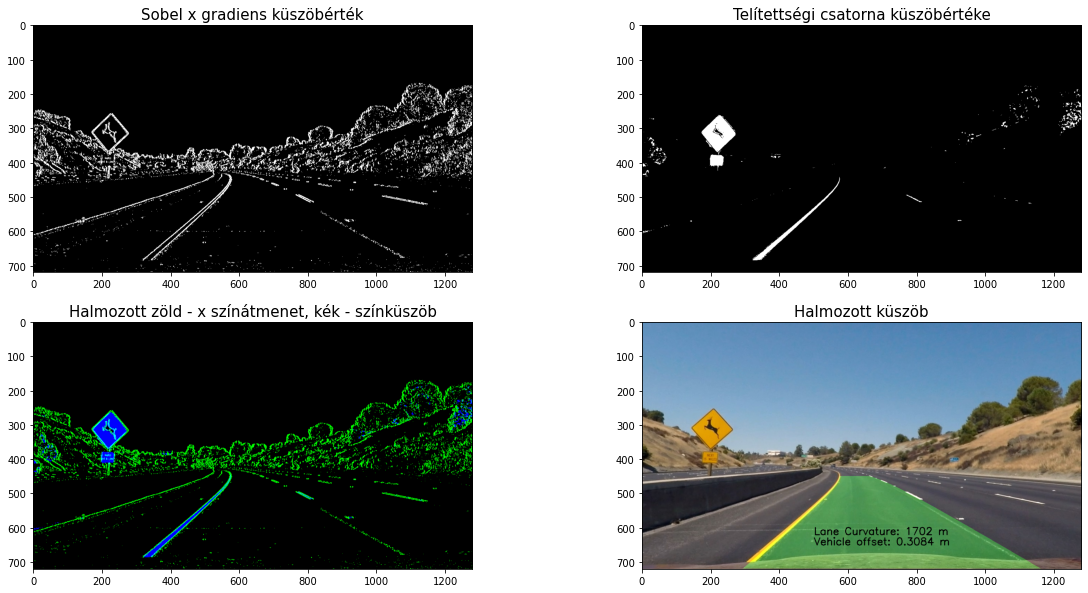

In [66]:
images = glob.glob(r'C:\Users\Eszti\Desktop\Python projects\curved_lane_test/*.jpg')

for indx, image in enumerate(images):
    plt.imshow(Pipeline(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)))
    plt.show()

### Polinom illesztés eredménye

C:\Users\Eszti\AppData\Local\Temp/ipykernel_14596/1734970146.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]//2)
C:\Users\Eszti\AppData\Local\Temp/ipykernel_14596/1734970146.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the releas

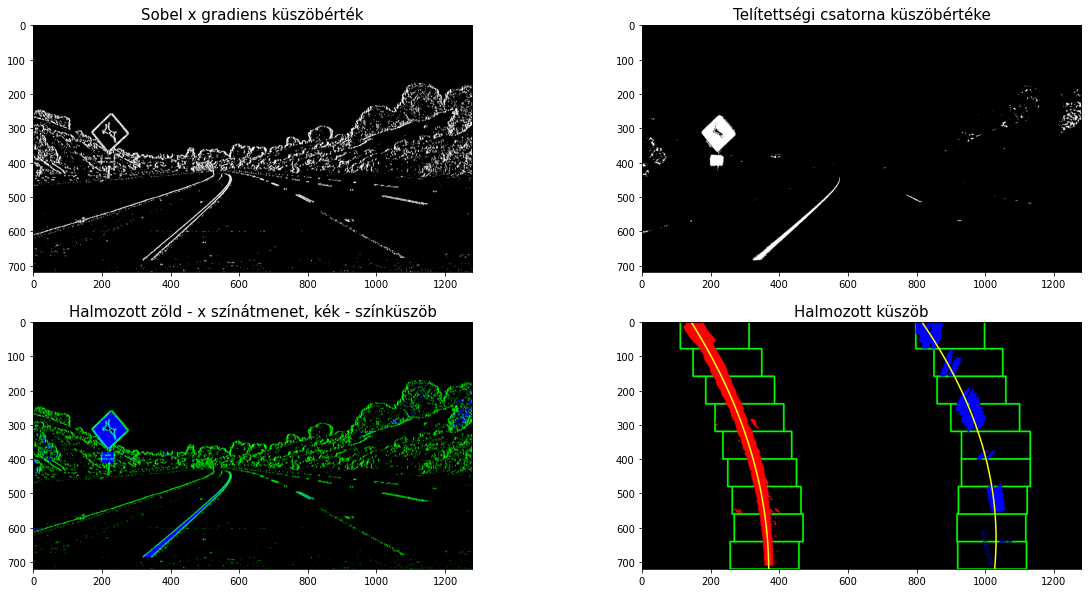

In [67]:
def find_lane_pixels(binary_warped):
    # Kép alsó feléről hisztogram felvétele
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Kimeneti kép, melyre az eredmény megrajzolásra kerül
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Hisztogram bal- és jobb oldali csúcsának megkeresése
    # Ezek a bal- és jobb oldali vonalak kiindulópontjai
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # hiperparaméterek
    # csúszó ablakok számának megadása
    nwindows = 9
    # Csúszó-ablakok szélessége +/- margó
    margin = 100
    # talált pixelek minimális száma, mely után az ablak tovább csúszik
    minpix = 200

    # Ablakok magasságának beállítása a kép magasságának megfelelően
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Összes nem nulla értékékű pixel x és y pozíciójának meghatározása
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Az aktuális pozíciók később frissülnek az egyes ablakokhoz
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Bal- és jobboldali pixelértékek számára üres listák létrehozása
    left_lane_inds = []
    right_lane_inds = []

   # Iteráció indul, mely végig lépked az ablakokon
    for window in range(nwindows):
        # bal-és jobboldali ablakok határainak megadása
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ###ablakkeret négy sarokpontjának x és y koordináta értékei az aktuális pozícióka függvényében frissülnek ###
        win_xleft_low   = leftx_current - margin
        win_xleft_high  = leftx_current + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
       # kitöltött téglalap rajzolása
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        
        ###kereten belüli nem nulla intenzitású pixelek azonosítása###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
  
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        
        # 0-tól eltérő pixelek hozzáadásra kerülnek a bal és jobboldali vonalak számára létrehozott tömbökhöz
        left_lane_inds.append(good_left_inds)
        #print(left_lane_inds)
        right_lane_inds.append(good_right_inds)
        
        #ablak közepe újból meghatározásra kerül, 
        #amennyiben a meghatározott minimális pixelszámnál több pixel található a kereten belül        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    #tömbsorozatok összefűzésre kerülnek 
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        #hiba elkerülése, ha a fentiek nem teljesülnek maradéktalanul
        pass

    # nullától eltérő bal és jobb x-y indexek kiszámítása
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# másodfokú polinom illesztése
def fit_polynomial(binary_warped):
    # sáv pixelek megtalálása
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    #### a polinom illesztése###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # x és y értékek az eredményhez
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Hiba elkerülése, ha bal- és jobb polinom nincs meg vagy hibás
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Vizualizáció ##
    # Bal és jobb sávvonalak színei
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Bal- és jobboldali polinomok ábrázolása a sávvonalakon
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

img = cv2.cvtColor(cv2.imread(r'C:\Users\Eszti\Desktop\Python projects\curved_lane_test/curve-lane.jpg'), cv2.COLOR_BGR2RGB)
threshold_img, undistorted_img = img_threshold(img)
warped_img = perspective_transform(threshold_img)
out_img = fit_polynomial(warped_img)

plt.imshow(out_img)